In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely import wkt

from setup import *

%load_ext autoreload
%autoreload 2

In [35]:
epa = pd.read_csv(data_dir+"EPA_SmartLocationDatabase_V3_Jan_2021_Final.csv")
epa_agg_guide = pd.read_csv(data_dir+"EPA_SmartLocations_CensusTractAggregationGuide.csv").fillna(0)

In [36]:
columns_keep = epa_agg_guide[epa_agg_guide['tract_keep']==1]['col_name'].tolist()
columns_sum = epa_agg_guide[epa_agg_guide['tract_sum']==1]['col_name'].tolist()
columns_wm_pop = epa_agg_guide[epa_agg_guide['tract_weighted_mean_pop']==1]['col_name'].tolist()
columns_wm_emp = epa_agg_guide[epa_agg_guide['tract_weighted_mean_emp']==1]['col_name'].tolist()
columns_wm_area = epa_agg_guide[epa_agg_guide['tract_weighted_mean_area']==1]['col_name'].tolist()

wm_pop = lambda x: np.ma.average(x, weights=epa.loc[x.index, "TotPop"])
wm_emp = lambda x: np.ma.average(x, weights=epa.loc[x.index, "TotEmp"])
wm_area = lambda x: np.ma.average(x, weights=epa.loc[x.index, "Ac_Unpr"])

aggregation = {x:'sum' for x in columns_sum}
aggregation.update({x:wm_pop for x in columns_wm_pop})
aggregation.update({x:wm_emp for x in columns_wm_emp})
aggregation.update({x:wm_area for x in columns_wm_area})

In [37]:
# filter to Illinois
epa = epa[epa['STATEFP'] == 17]

# remove the CBGs with >50% protected area
epa['pct_protected'] = 1-epa['Ac_Unpr'] / epa['Ac_Total']
epa = epa[epa['pct_protected'] < 0.5]

# Turn spatial unit to acre (D3* metrics are in square miles)
for x in columns_wm_area:
    if x[:2] == 'D3':
        epa[x] *= 640

In [38]:
epa_tract = epa.groupby(columns_keep, as_index=False).agg(aggregation)

/home/jtl/anaconda3/envs/dingyi_env/lib/python3.8/site-packages/numpy/ma/extras.py:623: RuntimeWarning: invalid value encountered in double_scalars
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl


In [39]:
# Filter out the tracts with no employment or no residents
epa_tract = epa_tract[(epa_tract['TotEmp'] > 0) & (epa_tract['TotPop'] > 0)]

In [40]:
def calculate_entropy(df, cols):
    s = df[cols].sum(axis=1)
    e = pd.Series(np.zeros(len(df)), index=df.index)
    for c in cols:
        e[df[c]>0] = e[df[c]>0] + df[df[c]>0][c]/s[df[c]>0] * np.log(df[df[c]>0][c]/s[df[c]>0])
    e = -e/np.log(len(cols))
    return e

In [41]:
epa_tract['E8MixA'] = calculate_entropy(epa_tract, ['E8_Ret','E8_off','E8_Ind','E8_Svc','E8_Ent','E8_Ed','E8_Hlth','E8_Pub'])
epa_tract['pop_income_entropy'] = calculate_entropy(epa_tract, ['R_LowWageWk','R_MedWageWk','R_HiWageWk'])
epa_tract['D2A_WRKEMP'] = epa_tract['Workers'] / epa_tract['TotEmp']
epa_tract['D2C_WREMLX'] = np.exp(-np.abs(epa_tract['D2A_WRKEMP']-1))


In [42]:
rename = {'E8MixA': 'employment_entropy',
          'D1D': 'activity_density',
          'D2C_WREMLX':'wrk_emp_balance',
          'D3AAO':'auto_oriented',
          'D3AMM':'multi_modal',
          'D3APO':'pedestrian_oriented'
         }
epa_tract = epa_tract.rename(columns=rename)

In [46]:
epa_tract_export = epa_tract[['STATEFP','COUNTYFP','TRACTCE','activity_density','employment_entropy','pop_income_entropy','wrk_emp_balance',
  'auto_oriented','multi_modal','pedestrian_oriented']]

In [47]:
epa_tract_export.to_csv(data_dir+"EPA_SmartLocations_CensusTract_export.csv", index=False)

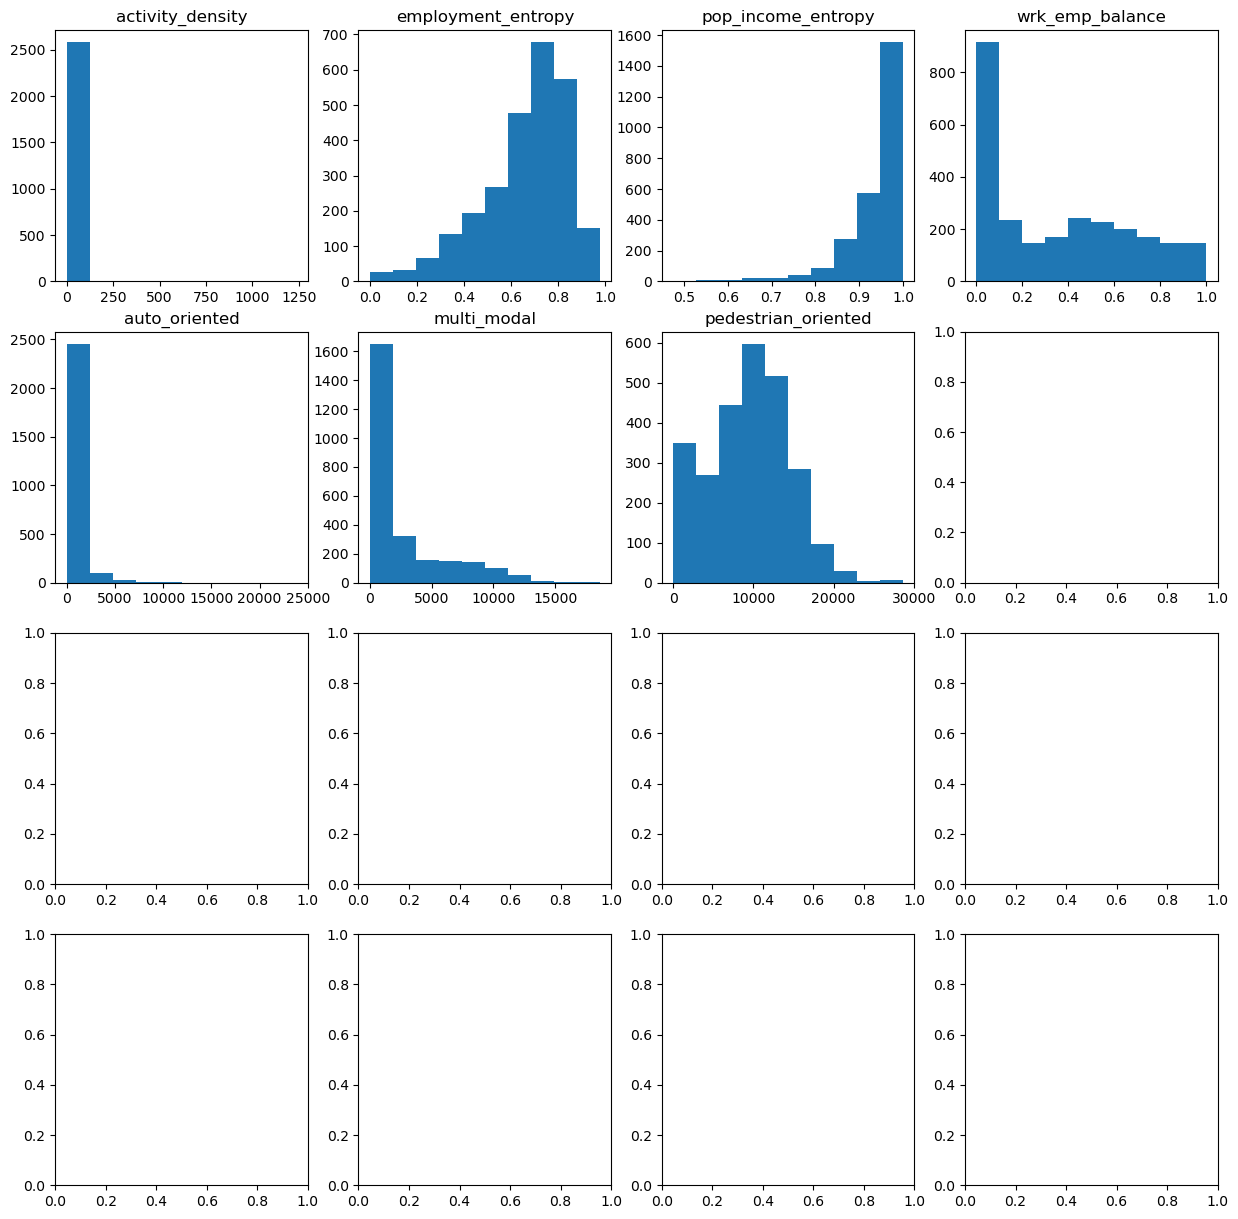

In [44]:
fig, ax = plt.subplots(4,4,figsize=(15,15))
i = 0
for c in epa_tract_export.columns:
    
    ax[i//4,i%4].hist(epa_tract_export[c])
    ax[i//4,i%4].set_title(c)
    i+=1

# PM2.5 concentration 

In [23]:
pm = pd.read_csv(data_dir+"Daily_Census_Tract-Level_PM2.5_Concentrations__2016.csv")


In [31]:
pm_illinois = pm[pm['statefips']==17]

In [33]:
pm_illinois = pm_illinois.groupby(['statefips','countyfips','ctfips'], as_index=False).mean()[['statefips','countyfips','ctfips','DS_PM_pred']]

In [53]:
pm_illinois = pm_illinois.rename(columns={'DS_PM_pred':'PM2.5'})

In [54]:
pm_illinois.to_csv(data_dir+"PM2.5_Concentrations_2016_Illinois_Average_Annual.csv", index=False)

# American Community Survey (Demogrpahics)

In [7]:
# demographic information of census blocks
demos = pd.read_csv(data_dir+'nhgis0004_ds239_20185_2018_blck_grp.csv')

data_cols = [x for x in list(demos.columns) if len(x) == 8 and x[0:2]=='AJ' and x[4]=='E']
# This will tell us if we have any non-numeic data types
# print(demo_to_grid[data_cols].dtypes.value_counts())
# Run this to find out which columns are non-numeric. Then can feed them to the next line
# demo_to_grid[data_cols].select_dtypes(include=['int64']).columns
data_cols.remove('AJ0EE001')

## Export Block Groups Level

In [8]:
travel_time_cols = ['AJXEE0'+str(i).zfill(2) for i in range(2,14)]
tt_medians = [2.5,7,12,17,22,27,32,37,42,52,74.5,100]

demo_census = demos.copy()

# create demographics for each cell.
demo_census['pct25_34yrs'] = (demo_census[['AJWBE011','AJWBE012',
                                         'AJWBE035','AJWBE036']].sum(axis = 1))/demo_census['AJWBE001']
demo_census['pct35_50yrs'] = (demo_census[['AJWBE013','AJWBE014','AJWBE015',
                                         'AJWBE037','AJWBE038','AJWBE039']].sum(axis = 1))/demo_census['AJWBE001']
demo_census['pctover65yrs'] = (demo_census[['AJWBE020','AJWBE021','AJWBE022','AJWBE023','AJWBE024','AJWBE025',
                                          'AJWBE044','AJWBE045','AJWBE046','AJWBE047','AJWBE048','AJWBE049']].sum(axis = 1))/demo_census['AJWBE001']
demo_census['pctwhite_alone'] = demo_census['AJWNE002']/demo_census['AJWNE001']
demo_census['pct_nonwhite'] = (demo_census['AJWNE001']-demo_census['AJWNE002'])/demo_census['AJWNE001']
demo_census['pctblack_alone'] = demo_census['AJWNE003']/demo_census['AJWNE001']
demo_census['pct_hs_grad'] = (demo_census[['AJYPE017','AJYPE018','AJYPE019','AJYPE020','AJYPE021','AJYPE022',
                                         'AJYPE023','AJYPE024','AJYPE025']].sum(axis = 1))/demo_census['AJYPE001']
demo_census['pct_col_grad'] = (demo_census[['AJYPE022','AJYPE023','AJYPE024','AJYPE025']].sum(axis = 1))/demo_census['AJYPE001']
demo_census['pctPTcommute'] = demo_census['AJXCE010']/demo_census['AJXCE001']

demo_census['25_34yrs'] = (demo_census[['AJWBE011','AJWBE012','AJWBE035','AJWBE036']].sum(axis = 1))
demo_census['35_50yrs'] = (demo_census[['AJWBE013','AJWBE014','AJWBE015', 'AJWBE037','AJWBE038','AJWBE039']].sum(axis = 1))
demo_census['over65yrs'] = (demo_census[['AJWBE020','AJWBE021','AJWBE022','AJWBE023','AJWBE024','AJWBE025',
                                          'AJWBE044','AJWBE045','AJWBE046','AJWBE047','AJWBE048','AJWBE049']].sum(axis = 1))
demo_census['white_alone'] = demo_census['AJWNE002']/demo_census['AJWNE001']
demo_census['nonwhite'] = demo_census['AJWNE001']-demo_census['AJWNE002']
demo_census['black_alone'] = demo_census['AJWNE003']
demo_census['hs_grad'] = (demo_census[['AJYPE017','AJYPE018','AJYPE019','AJYPE020','AJYPE021','AJYPE022',
                                         'AJYPE023','AJYPE024','AJYPE025']].sum(axis = 1))
demo_census['col_grad'] = (demo_census[['AJYPE022','AJYPE023','AJYPE024','AJYPE025']].sum(axis = 1))
demo_census['PTcommute'] = demo_census['AJXCE010']

demo_census['avg_tt_to_work'] = (demo_census[travel_time_cols].multiply(tt_medians, axis = 1).sum(axis =1))/demo_census['AJXEE001']

# create income info
# demo_census['pct60plusmincommute'] = (demo_census[['AJXEE012','AJXEE013']].sum(axis=1))/demo_census['AJXEE001']
cell_inc = demos.groupby(['COUNTYA','TRACTA','BLKGRPA'], as_index=False).apply(lambda x: 
                    (x['AJWME001']*x['AJ0EE001']).sum(axis = 0)/x['AJWME001'].sum(axis=0))
cell_inc.columns = ['COUNTYA', 'TRACTA', 'BLKGRPA', 'inc_per_capita']
demo_census = pd.merge(demo_census, cell_inc, how = 'left', on = ['COUNTYA', 'TRACTA', 'BLKGRPA'])


/tmp/ipykernel_23799/2290195772.py:38: RuntimeWarning: invalid value encountered in double_scalars
  (x['AJWME001']*x['AJ0EE001']).sum(axis = 0)/x['AJWME001'].sum(axis=0))


In [9]:
demo_df = demo_census[['COUNTYA', 'TRACTA', 'BLKGRPA','AJWME001',
                       'pct25_34yrs','pct35_50yrs','pctover65yrs',
                       'pctwhite_alone','pct_nonwhite','pctblack_alone',
                       'pct_col_grad','pctPTcommute',
                       '25_34yrs','35_50yrs','over65yrs',
                       'white_alone','nonwhite','black_alone',
                       'col_grad','PTcommute',
                       'avg_tt_to_work','inc_per_capita']].fillna(0)

demo_df = demo_df.rename(columns = {'AJWME001':'tot_population'})

demo_cols = ['tot_population','pct25_34yrs','pct35_50yrs','pctover65yrs',
         'pctwhite_alone','pct_nonwhite','pctblack_alone',
         'pct_col_grad','pctPTcommute','25_34yrs','35_50yrs','over65yrs',
         'white_alone','nonwhite','black_alone',
         'col_grad','PTcommute','avg_tt_to_work','inc_per_capita']

In [10]:
demo_df.to_csv(data_dir+"demo_blkgrp.csv", index=False)

## Export Tract Level

In [12]:
# aggregate values for each census tract.
demo_census = demos.groupby(['COUNTYA', 'TRACTA'], as_index=False)[data_cols].sum()

travel_time_cols = ['AJXEE0'+str(i).zfill(2) for i in range(2,14)]
tt_medians = [2.5,7,12,17,22,27,32,37,42,52,74.5,100]

# create demographics for each cell.
demo_census['pct25_34yrs'] = (demo_census[['AJWBE011','AJWBE012',
                                         'AJWBE035','AJWBE036']].sum(axis = 1))/demo_census['AJWBE001']
demo_census['pct35_50yrs'] = (demo_census[['AJWBE013','AJWBE014','AJWBE015',
                                         'AJWBE037','AJWBE038','AJWBE039']].sum(axis = 1))/demo_census['AJWBE001']
demo_census['pctover65yrs'] = (demo_census[['AJWBE020','AJWBE021','AJWBE022','AJWBE023','AJWBE024','AJWBE025',
                                          'AJWBE044','AJWBE045','AJWBE046','AJWBE047','AJWBE048','AJWBE049']].sum(axis = 1))/demo_census['AJWBE001']
demo_census['pctwhite_alone'] = demo_census['AJWNE002']/demo_census['AJWNE001']
demo_census['pct_nonwhite'] = (demo_census['AJWNE001']-demo_census['AJWNE002'])/demo_census['AJWNE001']
demo_census['pctblack_alone'] = demo_census['AJWNE003']/demo_census['AJWNE001']
demo_census['pct_hs_grad'] = (demo_census[['AJYPE017','AJYPE018','AJYPE019','AJYPE020','AJYPE021','AJYPE022',
                                         'AJYPE023','AJYPE024','AJYPE025']].sum(axis = 1))/demo_census['AJYPE001']
demo_census['pct_col_grad'] = (demo_census[['AJYPE022','AJYPE023','AJYPE024','AJYPE025']].sum(axis = 1))/demo_census['AJYPE001']
demo_census['pctPTcommute'] = demo_census['AJXCE010']/demo_census['AJXCE001']

demo_census['25_34yrs'] = (demo_census[['AJWBE011','AJWBE012','AJWBE035','AJWBE036']].sum(axis = 1))
demo_census['35_50yrs'] = (demo_census[['AJWBE013','AJWBE014','AJWBE015', 'AJWBE037','AJWBE038','AJWBE039']].sum(axis = 1))
demo_census['over65yrs'] = (demo_census[['AJWBE020','AJWBE021','AJWBE022','AJWBE023','AJWBE024','AJWBE025',
                                          'AJWBE044','AJWBE045','AJWBE046','AJWBE047','AJWBE048','AJWBE049']].sum(axis = 1))
demo_census['white_alone'] = demo_census['AJWNE002']/demo_census['AJWNE001']
demo_census['nonwhite'] = demo_census['AJWNE001']-demo_census['AJWNE002']
demo_census['black_alone'] = demo_census['AJWNE003']
demo_census['hs_grad'] = (demo_census[['AJYPE017','AJYPE018','AJYPE019','AJYPE020','AJYPE021','AJYPE022',
                                         'AJYPE023','AJYPE024','AJYPE025']].sum(axis = 1))
demo_census['col_grad'] = (demo_census[['AJYPE022','AJYPE023','AJYPE024','AJYPE025']].sum(axis = 1))
demo_census['PTcommute'] = demo_census['AJXCE010']

demo_census['avg_tt_to_work'] = (demo_census[travel_time_cols].multiply(tt_medians, axis = 1).sum(axis =1))/demo_census['AJXEE001']

# create income info
# demo_census['pct60plusmincommute'] = (demo_census[['AJXEE012','AJXEE013']].sum(axis=1))/demo_census['AJXEE001']
cell_inc = demos.groupby(['COUNTYA','TRACTA'], as_index=False).apply(lambda x: 
                    (x['AJWME001']*x['AJ0EE001']).sum(axis = 0)/x['AJWME001'].sum(axis=0))
cell_inc.columns = ['COUNTYA', 'TRACTA', 'inc_per_capita']
demo_census = pd.merge(demo_census, cell_inc, how = 'left', on = ['COUNTYA', 'TRACTA'])

demo_df = demo_census[['COUNTYA','TRACTA','AJWME001',
                       'pct25_34yrs','pct35_50yrs','pctover65yrs',
                       'pctwhite_alone','pct_nonwhite','pctblack_alone',
                       'pct_col_grad','pctPTcommute',
                       '25_34yrs','35_50yrs','over65yrs',
                       'white_alone','nonwhite','black_alone',
                       'col_grad','PTcommute',
                       'avg_tt_to_work','inc_per_capita']].fillna(0)

demo_df = demo_df.rename(columns = {'AJWME001':'tot_population'})

demo_df['geoid'] = '17_'+demo_df['COUNTYA'].astype(str)+'_'+demo_df['TRACTA'].astype(str)

/tmp/ipykernel_23799/2216518163.py:39: RuntimeWarning: invalid value encountered in double_scalars
  (x['AJWME001']*x['AJ0EE001']).sum(axis = 0)/x['AJWME001'].sum(axis=0))


## Census Tract Area

In [16]:
census_area = gpd.read_file(data_dir+"tl_2018_17_tract/tl_2018_17_tract.shp")

In [17]:
census_area['geometry'] = census_area['geometry'].to_crs('epsg:26916')
census_area['area'] = census_area['geometry'].area/1000000
census_area['geoid'] = census_area['STATEFP'].astype(str)+'_'+census_area['COUNTYFP'].str.lstrip('0')+'_'+census_area['TRACTCE'].str.lstrip('0')


In [18]:
census_area['INTPTLON'] = census_area['INTPTLON'].astype(float)
census_area['INTPTLAT'] = census_area['INTPTLAT'].astype(float)

In [19]:
demo_df = demo_df.merge(census_area[['geoid','area','INTPTLAT','INTPTLON']], on='geoid')

In [20]:
demo_df.to_csv(data_dir+"demo_tract.csv", index=False)

In [23]:
demo_df.columns

Index(['COUNTYA', 'TRACTA', 'tot_population', 'pct25_34yrs', 'pct35_50yrs',
       'pctover65yrs', 'pctwhite_alone', 'pct_nonwhite', 'pctblack_alone',
       'pct_col_grad', 'pctPTcommute', '25_34yrs', '35_50yrs', 'over65yrs',
       'white_alone', 'nonwhite', 'black_alone', 'col_grad', 'PTcommute',
       'avg_tt_to_work', 'inc_per_capita', 'geoid', 'area', 'INTPTLAT',
       'INTPTLON'],
      dtype='object')

## Crimes

In [ ]:
crimes = pd.read_csv(data_dir+"crimes_2021.csv")
crimes_code = pd.read_csv(data_dir+"NIBRS_criminal_code.csv")

crimes = pd.merge(crimes, crimes_code, on='FBI Code')

crimes.dropna(subset='Location', inplace=True)
crimes = crimes[['Date','FBI Code','FBI Code Category','Latitude','Longitude']]
crimes = gpd.GeoDataFrame(crimes, geometry=gpd.points_from_xy(crimes.Longitude, crimes.Latitude), crs='epsg:4326')